In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

import random
import numpy as np
import pandas as pd
random.seed(42)
np.random.seed(42)

# !pip install plotly
import plotly
import plotly.graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode
init_notebook_mode(connected=True)
# import plotly_express as px

In [3]:
train = pd.read_csv('./train_90_df.csv', index_col=0)
test = pd.read_csv('./test_90_df.csv', index_col=0)
train_y = train['vent_duration']
train_x = train.drop(['stay_id', 'vent_duration', 'icu_intime', 'vent_start'], axis=1)
test_y = test['vent_duration']
test_x = test.drop(['stay_id', 'vent_duration', 'icu_intime', 'vent_start'], axis=1)
train_x.head()

,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc
0,-3.840278,8.0,0.7,114.0,135.0,103.0,13.0,5.1
1,-0.240278,6.8,0.7,133.0,135.0,102.0,11.8,4.8
2,-14.611667,8.0,0.8,156.0,132.0,102.0,10.1,8.2
3,0.521667,7.1,1.0,89.0,136.0,108.0,9.9,9.5
4,0.518056,8.2,1.6,124.0,130.0,100.0,8.3,27.0


## Regression Models

In [4]:
# compare the predicted and ground truth
import matplotlib.pyplot as plt
def visualize(test_y, pred_y):
  plt.figure(figsize=(10, 5))
  plt.plot(test_y)
  plt.plot(pred_y)
  plt.legend(['ground truth', 'prediction'])
  plt.show()

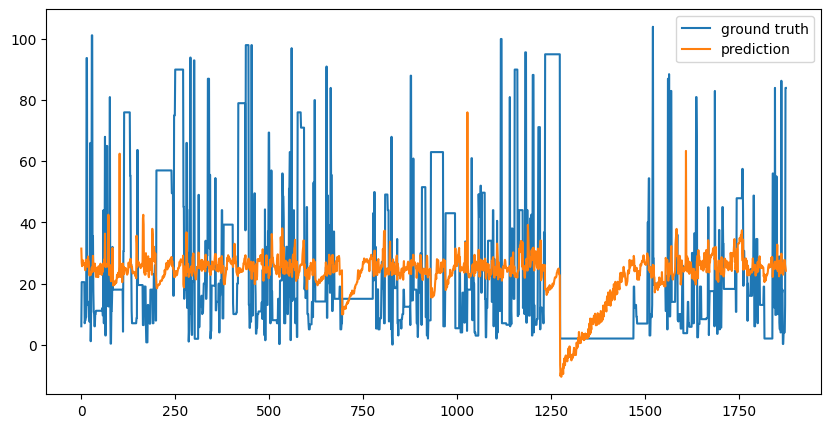

25.630634007352153

In [5]:
# Linear Regression
from sklearn.linear_model import LinearRegression
linear_pipeline = Pipeline([('scaler', RobustScaler()), ('linear_model', LinearRegression())])
linear_pipeline.fit(train_x, train_y)
pred_y = linear_pipeline.predict(test_x)
visualize(test_y, pred_y)
mean_squared_error(test_y, pred_y, squared=False)

/Users/zhoujiahui/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning:

Training interrupted by user.



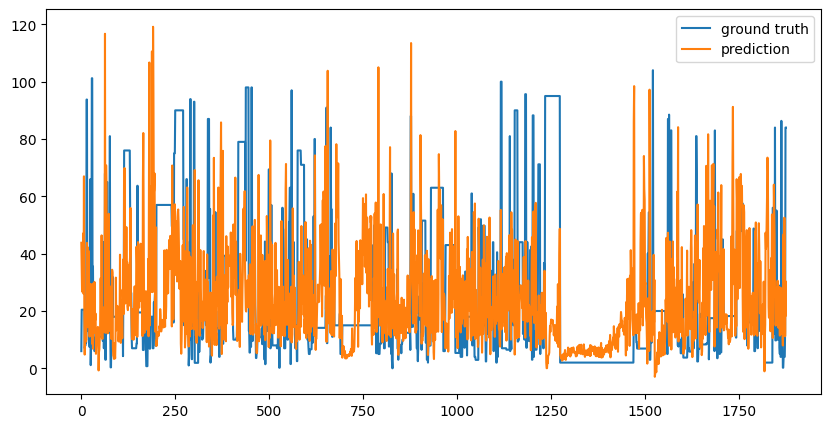

29.44744827414279

In [6]:
# MLP Regressor
from sklearn.neural_network import MLPRegressor
mlp_pipeline = Pipeline([('scaler', RobustScaler()), ('mlp_model', MLPRegressor(hidden_layer_sizes=(100, 512, 100), max_iter=1000, learning_rate="adaptive"))])
mlp_pipeline.fit(train_x, train_y)
pred_y = mlp_pipeline.predict(test_x)
visualize(test_y, pred_y)
mean_squared_error(test_y, pred_y, squared=False)

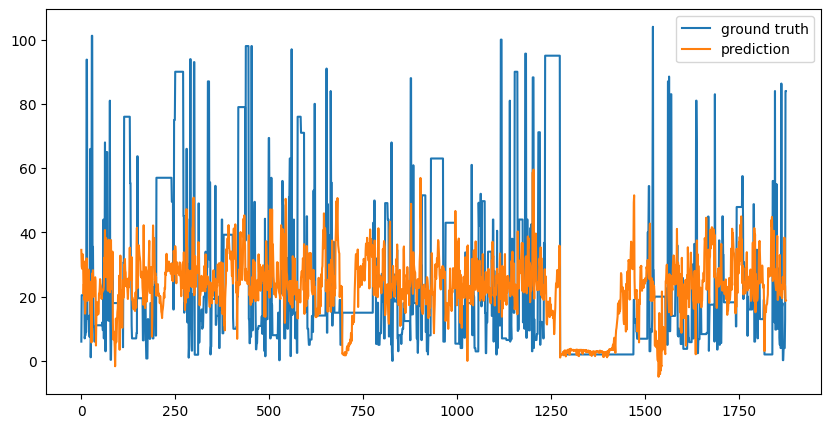

25.870672142813916

In [ ]:
# RBF kernels
from sklearn.kernel_ridge import KernelRidge
rbf_pipeline = Pipeline([('scaler', RobustScaler()), ('rbf_model', KernelRidge(kernel='rbf', gamma=0.05))])
rbf_pipeline.fit(train_x, train_y)
pred_y = rbf_pipeline.predict(test_x)
visualize(test_y, pred_y)
mean_squared_error(test_y, pred_y, squared=False)

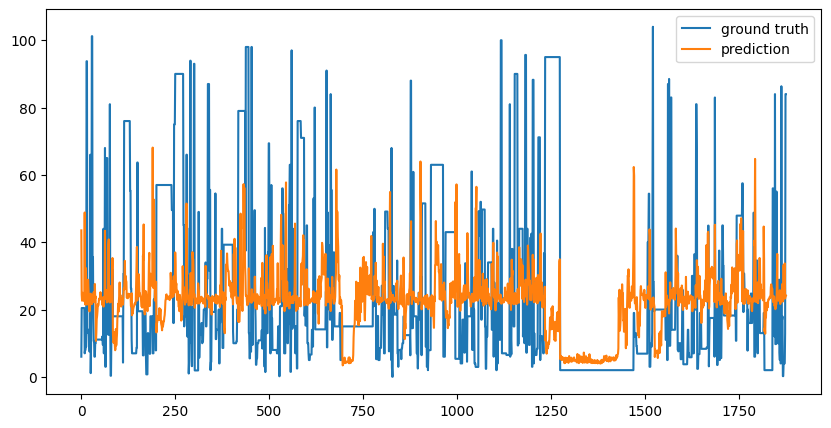

26.064511647446757

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf_pipeline = Pipeline([('scaler', StandardScaler()), ('rf_model', RandomForestRegressor(n_estimators=100, max_depth=10))])
rf_pipeline.fit(train_x, train_y)
pred_y = rf_pipeline.predict(test_x)
visualize(test_y, pred_y)
mean_squared_error(test_y, pred_y, squared=False)

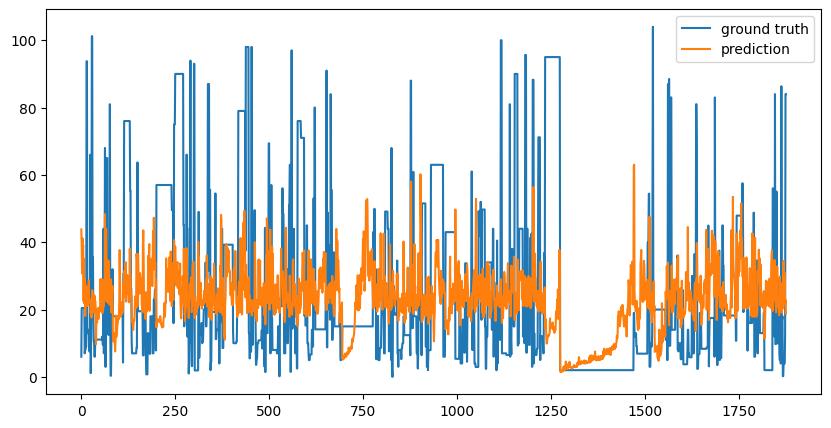

25.86113400960493

In [ ]:
# Voting Regressor
from sklearn.ensemble import VotingRegressor
voting_pipeline = Pipeline([('scaler', RobustScaler()), ('voting_model', VotingRegressor([('linear', linear_pipeline), ('mlp', mlp_pipeline), ('rbf', rbf_pipeline), ('rf', rf_pipeline)]))])
voting_pipeline.fit(train_x, train_y)
pred_y = voting_pipeline.predict(test_x)
visualize(test_y, pred_y)
mean_squared_error(test_y, pred_y, squared=False)

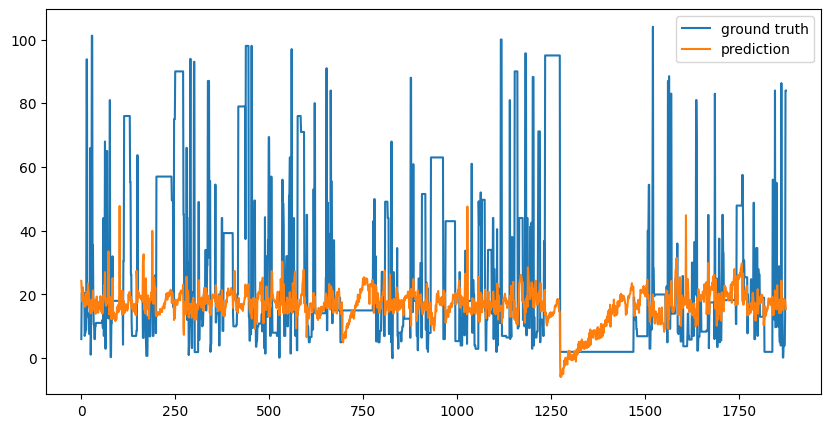

27.04612657386863

In [ ]:
# Linear SVM
from sklearn.svm import LinearSVR
svm_pipeline = Pipeline([('scaler', RobustScaler()), ('svm_model', LinearSVR(max_iter=10000))])
svm_pipeline.fit(train_x, train_y)
pred_y = svm_pipeline.predict(test_x)
visualize(test_y, pred_y)
mean_squared_error(test_y, pred_y, squared=False)

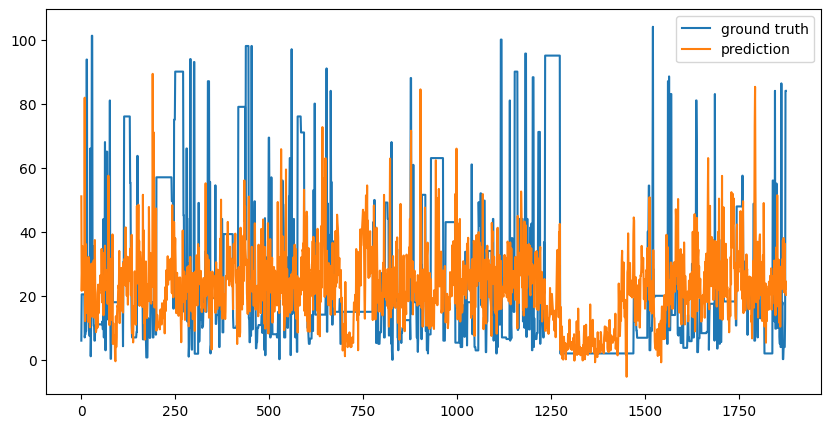

27.078765347123984

In [ ]:
# Use xgboost to predict
import xgboost as xgb
xgb_pipeline = Pipeline([('scaler', RobustScaler()), ('xgb_model', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=10, alpha=1, learning_rate=0.1))])
xgb_pipeline.fit(train_x, train_y)
pred_y = xgb_pipeline.predict(test_x)
visualize(test_y, pred_y)
mean_squared_error(test_y, pred_y, squared=False)

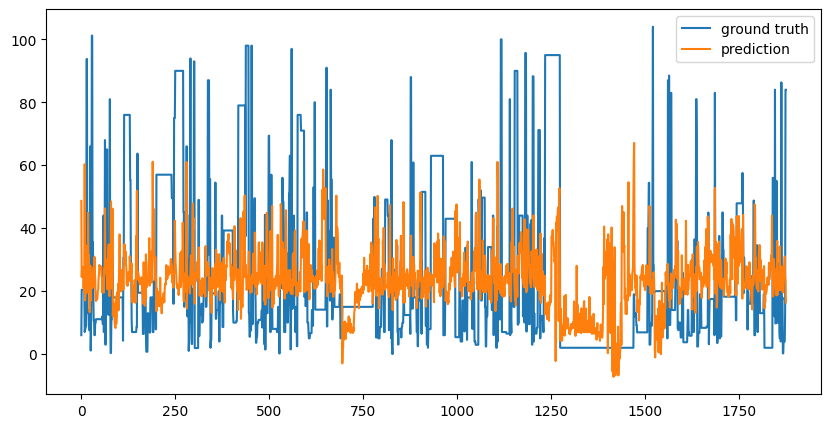

26.00548364079633

In [ ]:
# Use grid search to find the best parameters of lightgbm
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
lgbm_pipeline = Pipeline([('scaler', RobustScaler()), ('lgbm_model', LGBMRegressor())])
param_grid = {
    'lgbm_model__n_estimators': [100, 200, 300],
    'lgbm_model__max_depth': [10, 20, 30],
    'lgbm_model__learning_rate': [0.1, 0.2, 0.3],
    'lgbm_model__num_leaves': [10, 20, 30]
}
grid_search = GridSearchCV(lgbm_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(train_x, train_y)
grid_search.best_params_

# predict using the fitted model
pred_y = grid_search.predict(test_x)
visualize(test_y, pred_y)
mean_squared_error(test_y, pred_y, squared=False)

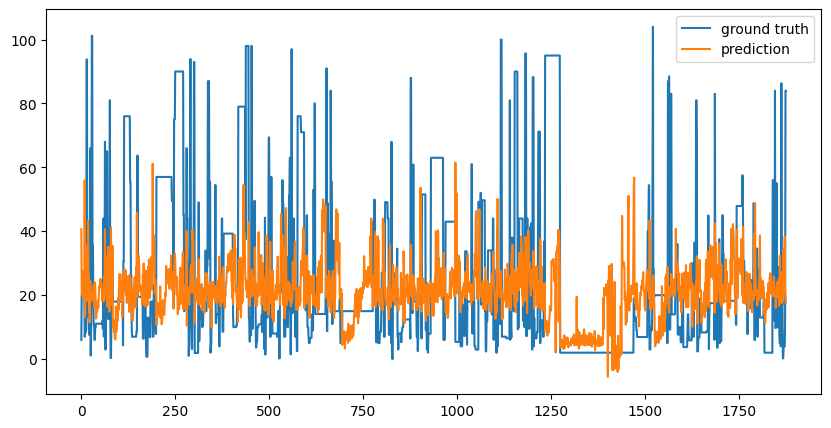

26.133457649174407

In [ ]:
# Use lightgbm to predict
import lightgbm as lgb
lgb_pipeline = Pipeline([('scaler', RobustScaler()), ('lgb_model', lgb.LGBMRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, objective='regression', boosting_type='dart'))])
lgb_pipeline.fit(train_x, train_y)
pred_y = lgb_pipeline.predict(test_x)
visualize(test_y, pred_y)
mean_squared_error(test_y, pred_y, squared=False)

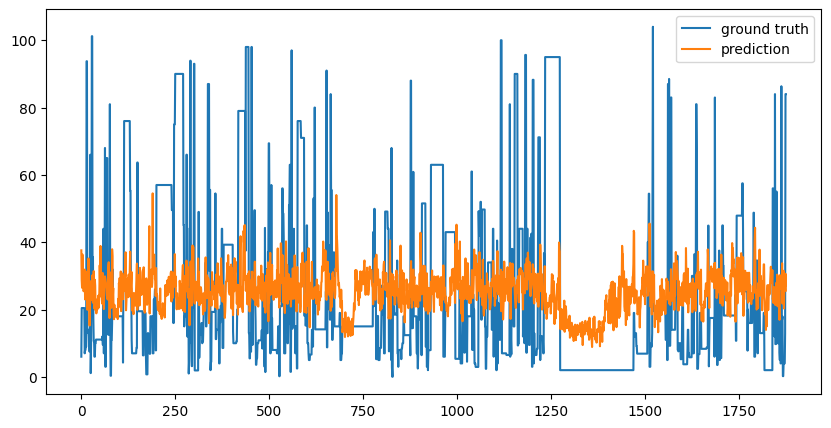

25.65146749938051

In [ ]:
# Bagging regressor
from sklearn.ensemble import BaggingRegressor
bagging_pipeline = Pipeline([('scaler', RobustScaler()), ('bagging_model', BaggingRegressor(n_estimators=100, max_samples=0.5, max_features=0.5))])
bagging_pipeline.fit(train_x, train_y)
pred_y = bagging_pipeline.predict(test_x)
visualize(test_y, pred_y)
mean_squared_error(test_y, pred_y, squared=False)

## Classification Models

In [7]:
# MLP Classifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
mlp_pipeline = Pipeline([('scaler', RobustScaler()), ('mlp_model', MLPClassifier(hidden_layer_sizes=(100, 512, 100), max_iter=1000, learning_rate="adaptive"))])
mlp_pipeline.fit(train_x, train_y.map(lambda x: 1 if x > 50 else 0))
pred_y = mlp_pipeline.predict(test_x)
confusion_matrix(test_y.map(lambda x: 1 if x > 50 else 0), pred_y)
train_x['aux'] = mlp_pipeline.predict(train_x)
test_x['aux'] = mlp_pipeline.predict(test_x)

In [8]:
train_x.describe()

,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,aux
count,3623.000000,3623.000000,3623.000000,3623.000000,3623.000000,3623.000000,3623.000000,3623.000000,3623.000000
mean,-124.673917,8.409495,1.730555,141.967706,137.151256,101.752691,10.058929,10.918576,0.134695
std,411.778037,0.789700,1.974254,79.043113,5.777083,6.797993,2.005580,7.123290,0.341445
min,-3440.494722,4.200000,0.100000,30.000000,83.000000,62.000000,3.900000,0.100000,0.000000
25%,-75.406806,8.000000,0.800000,104.000000,134.000000,98.000000,8.600000,7.100000,0.000000
50%,-3.906667,8.400000,1.100000,126.000000,138.000000,102.000000,9.900000,9.500000,0.000000
75%,3.975000,8.800000,1.900000,157.000000,141.000000,106.000000,11.100000,12.900000,0.000000
max,11.998889,12.300000,19.500000,2172.000000,160.000000,127.000000,17.600000,125.200000,1.000000


In [9]:
# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

alpha = 0.1

## Predict lower bound
lower_pipeline = Pipeline([('scaler', RobustScaler()), ('lower_model', GradientBoostingRegressor(loss="quantile", alpha=alpha, n_estimators=100, max_depth=10))])

## Predict upper bound
upper_pipeline = Pipeline([('scaler', RobustScaler()), ('upper_model', GradientBoostingRegressor(loss="quantile", alpha=1-alpha, n_estimators=100, max_depth=10))])

## Predict median
median_pipeline = Pipeline([('scaler', RobustScaler()), ('median_model', GradientBoostingRegressor(loss="quantile", alpha=0.5, n_estimators=100, max_depth=10))])

lower_pipeline.fit(train_x, train_y)
upper_pipeline.fit(train_x, train_y)
median_pipeline.fit(train_x, train_y)

pred_lower = lower_pipeline.predict(test_x)
pred_upper = upper_pipeline.predict(test_x)
pred_median = median_pipeline.predict(test_x)

predictions = pd.DataFrame(test_y)
predictions['pred_lower'] = pred_lower
predictions['pred_upper'] = pred_upper
predictions['pred_median'] = pred_median
mean_squared_error(test_y, pred_median, squared=False)

29.405196157548506

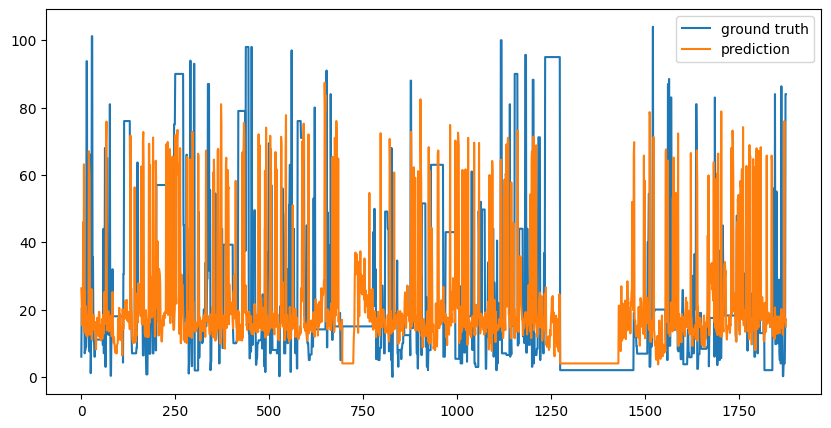

In [10]:
predictions
visualize(test_y, pred_median)

In [ ]:
# Credit to: https://github.com/WillKoehrsen/Data-Analysis/blob/master/prediction-intervals/prediction_intervals.ipynb
def plot_intervals(predictions, mid=False, start=None, stop=None, title=None):
    """
    Function for plotting prediction intervals as filled area chart.
    
    :param predictions: dataframe of predictions with lower, upper, and actual columns (named for the target)
    :param whether to show the mid prediction
    :param start: optional parameter for subsetting start of predictions
    :param stop: optional parameter for subsetting end of predictions
    :param title: optional string title
    
    :return fig: plotly figure
    """
    # Subset if required
    predictions = (
        predictions.loc[start:stop].copy()
        if start is not None or stop is not None
        else predictions.copy()
    )
    data = []

    # Lower trace will fill to the upper trace
    trace_low = go.Scatter(
        x=predictions.index,
        y=predictions["pred_lower"],
        fill="tonexty",
        line=dict(color="darkblue"),
        fillcolor="rgba(173, 216, 230, 0.4)",
        showlegend=True,
        name="lower",
    )
    # Upper trace has no fill
    trace_high = go.Scatter(
        x=predictions.index,
        y=predictions["pred_upper"],
        fill=None,
        line=dict(color="orange"),
        showlegend=True,
        name="upper",
    )

    # Must append high trace first so low trace fills to the high trace
    data.append(trace_high)
    data.append(trace_low)
    
    if mid:
        trace_mid = go.Scatter(
        x=predictions.index,
        y=predictions["pred_median"],
        fill=None,
        line=dict(color="green"),
        showlegend=True,
        name="mid",
    )
    data.append(trace_mid)

    # Trace of actual values
    trace_actual = go.Scatter(
        x=predictions.index,
        y=predictions["vent_duration"],
        fill=None,
        line=dict(color="black"),
        showlegend=True,
        name="actual",
    )
    data.append(trace_actual)

    # Layout with some customization
    layout = go.Layout(
        height=900,
        width=1400,
        title=dict(text="Prediction Intervals" if title is None else title),
        yaxis=dict(title=dict(text="vent_duration/h")),
        xaxis=dict(
            rangeselector=dict(
                buttons=list(
                    [
                        dict(step="all"),
                    ]
                )
            ),
            rangeslider=dict(visible=True),
            type="-",
            title="Patients"
        ),
    )

    fig = go.Figure(data=data, layout=layout)

    # Make sure font is readable
    fig["layout"]["font"] = dict(size=20)
    fig.layout.template = "plotly_white"
    return fig


In [ ]:
fig = plot_intervals(predictions.sort_values(by='vent_duration').reset_index(), mid=True)
iplot(fig)

In [ ]:
from sklearn.model_selection import GridSearchCV
# try different quantile to predict
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# try different max_depth
# max_depth = [5, 10, 15, 20, 25, 30]
max_depth = [10]
# try different n_estimators
# n_estimators = [50, 100, 150, 200, 250, 300]
n_estimators = [100]
# try different learning_rate
# learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
learning_rate = [0.1]
# use GradientBoostingRegressor
model = GradientBoostingRegressor(loss="quantile")
# use GridSearchCV to find the best parameters
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alpha, max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate), verbose=10)
grid.fit(train_x, train_y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)
print(grid.best_estimator_.max_depth)
print(grid.best_estimator_.n_estimators)
print(grid.best_estimator_.learning_rate)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START alpha=0.1, learning_rate=0.1, max_depth=10, n_estimators=100
[CV 1/5; 1/9] END alpha=0.1, learning_rate=0.1, max_depth=10, n_estimators=100;, score=0.332 total time=   2.9s
[CV 2/5; 1/9] START alpha=0.1, learning_rate=0.1, max_depth=10, n_estimators=100
[CV 2/5; 1/9] END alpha=0.1, learning_rate=0.1, max_depth=10, n_estimators=100;, score=0.339 total time=   2.6s
[CV 3/5; 1/9] START alpha=0.1, learning_rate=0.1, max_depth=10, n_estimators=100
[CV 3/5; 1/9] END alpha=0.1, learning_rate=0.1, max_depth=10, n_estimators=100;, score=0.188 total time=   2.4s
[CV 4/5; 1/9] START alpha=0.1, learning_rate=0.1, max_depth=10, n_estimators=100
[CV 4/5; 1/9] END alpha=0.1, learning_rate=0.1, max_depth=10, n_estimators=100;, score=0.231 total time=   2.0s
[CV 5/5; 1/9] START alpha=0.1, learning_rate=0.1, max_depth=10, n_estimators=100
[CV 5/5; 1/9] END alpha=0.1, learning_rate=0.1, max_depth=10, n_estimators=100;, score=

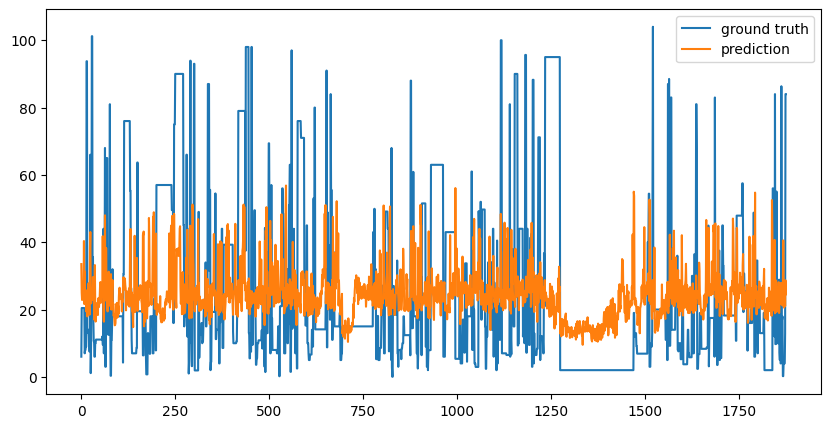

25.76724051392385

In [ ]:
# Bagging regressor
from sklearn.ensemble import BaggingRegressor
bagging_pipeline = Pipeline([('scaler', RobustScaler()), ('bagging_model', BaggingRegressor(n_estimators=100, max_samples=0.5, max_features=0.5))])
bagging_pipeline.fit(train_x, train_y)
pred_y = bagging_pipeline.predict(test_x)
visualize(test_y, pred_y)
mean_squared_error(test_y, pred_y, squared=False)

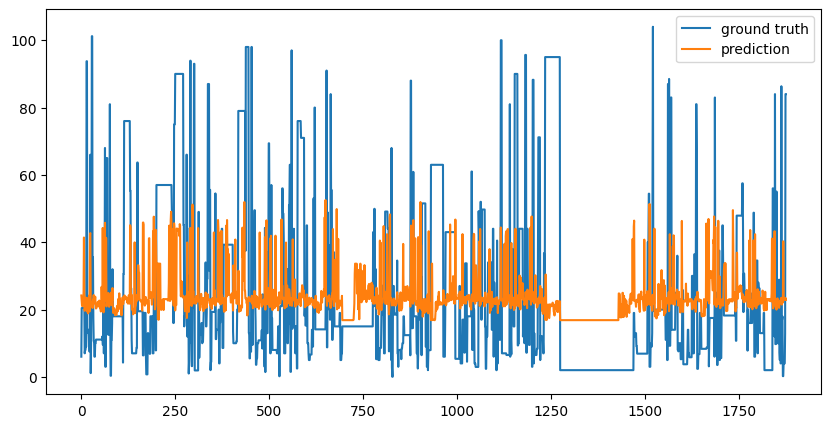

25.802556928924798

In [ ]:
# Gradient Boosting regressor
from sklearn.ensemble import GradientBoostingRegressor
gb_pipeline = Pipeline([('scaler', RobustScaler()), ('gb_model', GradientBoostingRegressor(n_estimators=100, max_depth=10, learning_rate=0.005))])
gb_pipeline.fit(train_x, train_y)
pred_y = gb_pipeline.predict(test_x)
visualize(test_y, pred_y)
mean_squared_error(test_y, pred_y, squared=False)